<a href="https://colab.research.google.com/github/clovisdanielss/Estudando/blob/master/Python%20Scripts/time-series/Time_Series_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives

First we will define the behaviors of a time series to understand a little 
about this type of data. 

Also we'll analise a random generate time series and try to predict using some models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [3]:
def trend(time, slope=0):
  return slope*time

Let's create a time series that just trends upward:

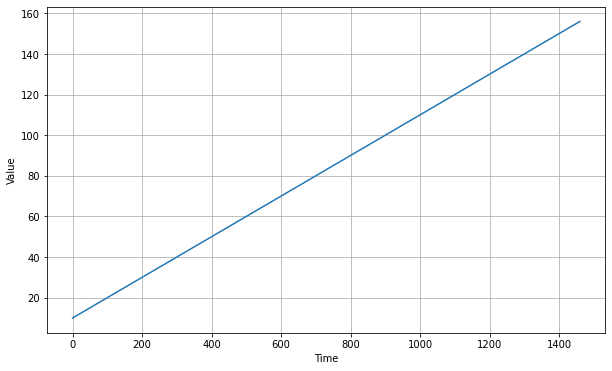

In [4]:
time = np.arange(4*365 + 1)
baseline = 10
series = baseline + trend(time, .1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [5]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

Let's create a time series with seasonal pattern

In [6]:
def seasonal_pattern(season_time):
  """Just an ordinary pattern"""
  return np.where(season_time < .4, np.cos(season_time * 2 * np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase)%period)/period
  return amplitude* seasonal_pattern(season_time)

**Notes:**

>The **period** defines how often the pattern is repeated. 

>The **amplitude** define how high the pattern will be.

>The phase defines how shifted the pattern will be

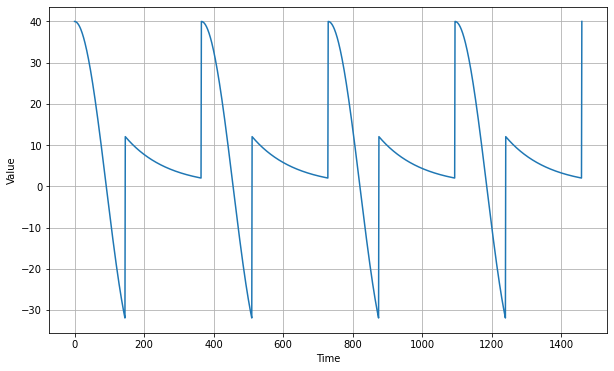

In [7]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

A time serie can have both treand and seasonality.

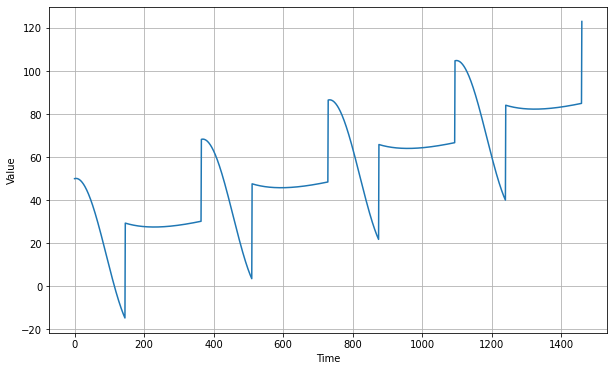

In [8]:
amplitude = 40
slope = .05
series = seasonality(time, period=365, amplitude=amplitude) + baseline + trend(time, slope)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

But what those examples are missing is the **noise**. Because in real life the curves are not that smooth. 

In [9]:
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

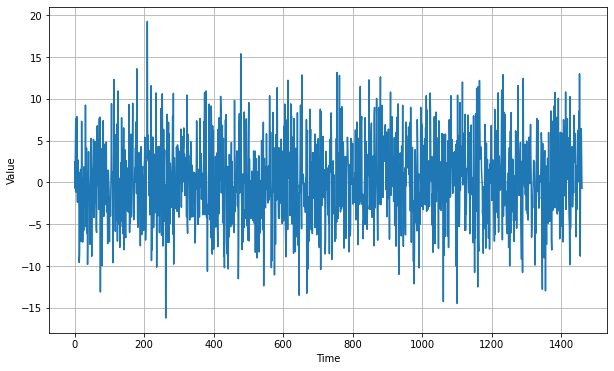

In [10]:
noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, noise)
plt.show()

Now let's see the three behaviors together

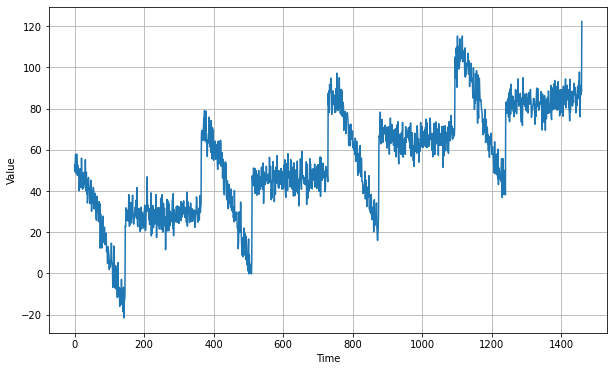

In [11]:
noise_level = 5
noise = series + white_noise(time, noise_level=noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, noise)
plt.show()

**Key Concept**:

So we can have three types of behavior in a time series:

> Seasonal behavior - How the value behaves in a given interval of time.

> Trend behavior - A general tendency in a given interval of time.

> Noise behavior - The variance in the data.

#### Forecasting

We want to learn how to forecast a time series. First of, we need to understand the naive concept of forecast. 

> Naive forecasting - repeat the most recent known value.

How to measure It's performance ? To do so, we must divide the data as we are used to divide when applying ML to other problems. But, in this case we divide by periods. 

> Fixed partitioning - It's the concept of divide the data in training period, validation period and test period

If the data has a sesional behavior, our split data must include all the sessions we're working with.

When we are in the validation of our model, It's important to use only the training data. But when we go to the test phase, we must train the model with both validation and training data. 

At last, in the deploying phase, the model must be training with all dataset, including the test data.

> This happens because in time series, the most useful information is the most recent one.


### Now we'll apply an model to the previous data. 

In [12]:
series = series + white_noise(time, noise_level=noise_level, seed=42)
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#### Naive forecast

In [13]:
naive_forecast = series[split_time - 1: -1]

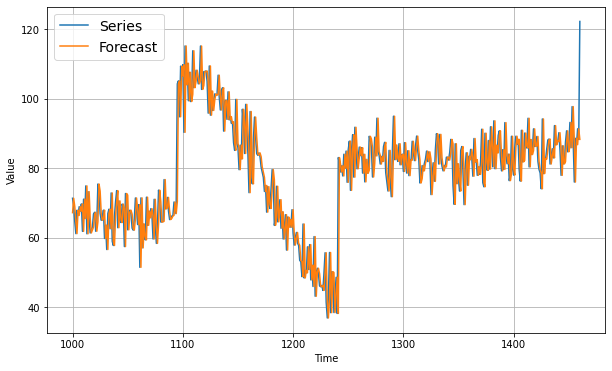

In [14]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

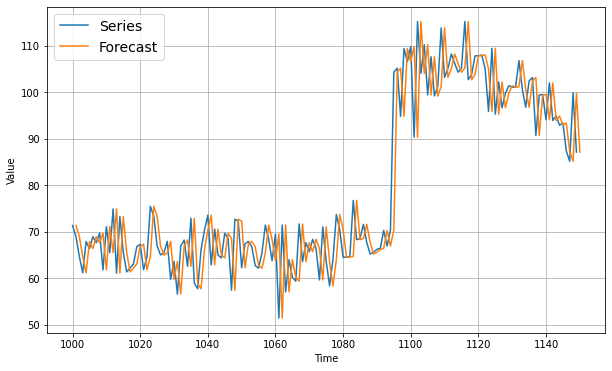

In [15]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

#### Observing the error

In [16]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

#### Moving Forecasting

In [17]:
def moving_avarage_forecasting(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return forecast

In [18]:
def moving_avarage_forecasting(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size-1:-1]/window_size

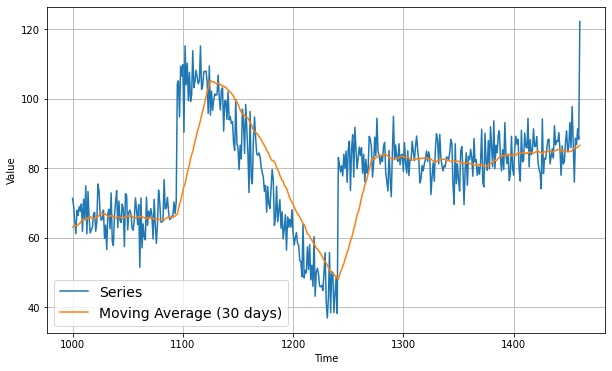

In [19]:
ws=30
moving_avg = moving_avarage_forecasting(series, ws)[split_time - ws:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label=f"Moving Average ({ws} days)")

There's a delay between the forecast and the labels values. We are not predictiong the sesionality.

In [20]:
errors = moving_avg - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

7.142418570620785

To make it better, we can remove the trend and remove the seasonality. 


Since the seasionality period is 365 days we will subtract the value at time `t-365` from the value at time `t`

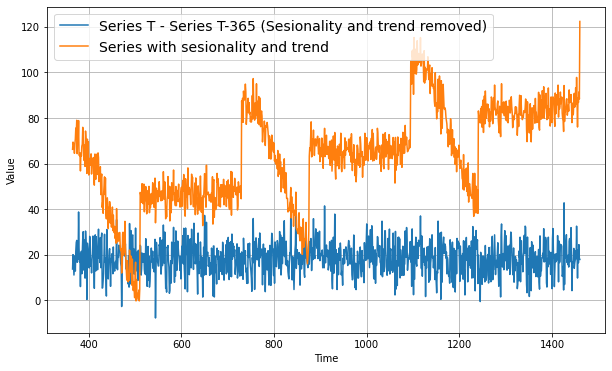

In [21]:
diff_series = (series[365:] - series[:-365])
dif_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(dif_time, diff_series, label=f"Series T - Series T-365 (Sesionality and trend removed)")
plot_series(dif_time, series[365:], label=f"Series with sesionality and trend")

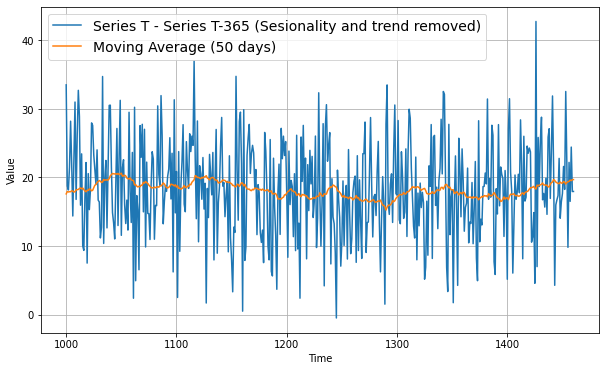

In [22]:
ws=50
moving_avg = moving_avarage_forecasting(diff_series, ws)[split_time - 365 - ws:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time-365:], label="Series T - Series T-365 (Sesionality and trend removed)")
plot_series(time_valid, moving_avg, label=f"Moving Average ({ws} days)")

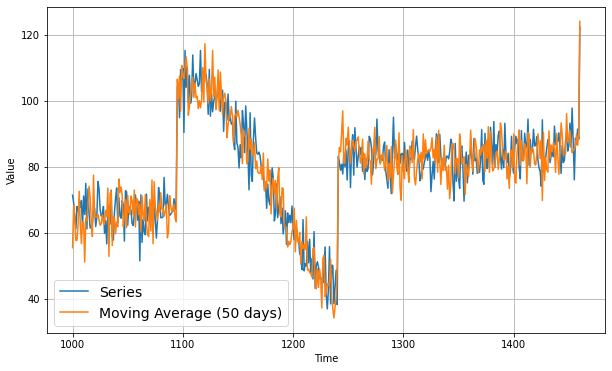

In [23]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label=f"Moving Average ({ws} days)")

In [24]:
errors = diff_moving_avg_plus_past - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.839310562995897

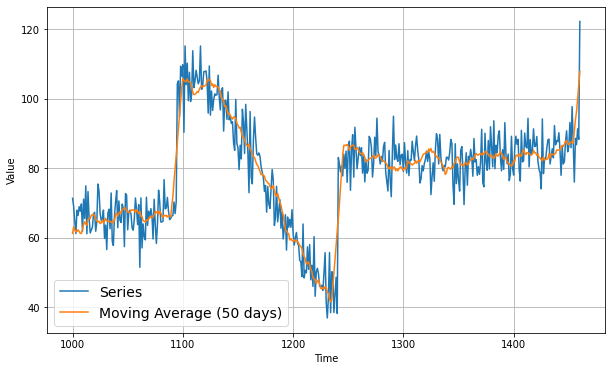

In [25]:
diff_moving_avg_smooth_plus_past = moving_avarage_forecasting(series[split_time -370:-359], 11) + moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_smooth_plus_past, label=f"Moving Average ({ws} days)")

In [26]:
errors = diff_moving_avg_smooth_plus_past - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

4.566859958970773

### Using ML

Without any ML techniques we build a model with low noise, and whitch the MAE is only 4.5, thats great. Let's now check what we can do with a ML model.

Our model should recieve as input a time window and give the next time window as forecast

#### Using a Keras model

Let's see some useful keras functions. 

The first function I want to see here is the `dataset.window` whitch splits the dataset in windows with `shift` distance. Let's look the example.

In [27]:
import tensorflow as tf

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window in dataset:
  for val in window:
    print(val.numpy(), end= " ")
  print()
  

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In the above example, we see all the windows. But, each element is represented as an tensor, that is why we used the logic in the loop to print each window in each line.

To solve this problem, and make each window as an tensor we can use `dataset.flat_map` and call a lambda funcion like `lambda window: window.batch(5)` whitch batches all 5 values in each window.

In [28]:
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Still, if we want to make a time series forecasting, we want to predict the next value from the window. So we must split each window, making the last element by itself. 

In [29]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[4 5 6 7] [8]
[3 4 5 6] [7]
[0 1 2 3] [4]
[5 6 7 8] [9]
[1 2 3 4] [5]


Now we can use our dataset with batches applying the `dataset.batch`. The `dataset.prefetch` is useful during the training, because while training using the current batch, tensorflow will be preparing the next batch in parallel. 

In [30]:
for x,y in dataset.batch(2).prefetch(1):
  print(f"x = {x.numpy()}\ny = {y.numpy()}")

x = [[1 2 3 4]
 [5 6 7 8]]
y = [[5]
 [9]]
x = [[3 4 5 6]
 [0 1 2 3]]
y = [[7]
 [4]]
x = [[4 5 6 7]
 [2 3 4 5]]
y = [[8]
 [6]]


In [31]:
def window_dataset(x, window_size, batch_size=32, suffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(x)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
  dataset = dataset.shuffle(suffle_buffer)
  dataset = dataset.map(lambda w: (w[:-1], w[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Remembering our data

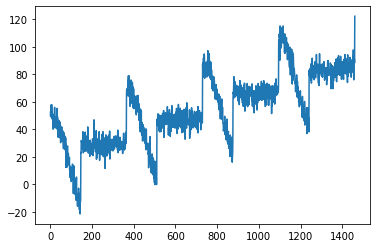

In [32]:
plt.plot(time, series)
ws = 30
train_set = window_dataset(x_train, ws)
valid_set = window_dataset(x_valid, ws)

Checking the best lr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


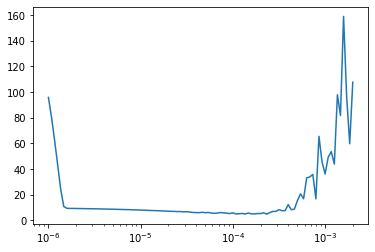

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[ws])
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=.9),
    loss=tf.keras.losses.Huber(), # Greater erros penalize using a linear funcion. Lower errors quadratic function
    metrics=["mae"]
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: 1e-6 * 10 ** (epoch/30))

log = model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[lr_schedule],
    verbose=False
)

plt.semilogx(log.history["lr"], log.history["loss"])

As you can see, a secure range for use a lerning rate should be [1e-5,1e-4]. Anything greater than that wont converge, anything lesser than that will be too slow.

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[ws])
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=.9),
    loss=tf.keras.losses.Huber(), # Greater erros penalize using a linear funcion. Lower errors quadratic function
    metrics=["mae"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 11ms/step - loss: 14.7873 - mae: 15.2777 - val_loss: 12.8298 - val_mae: 13.3244
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 10.9200 - mae: 11.4085 - val_loss: 10.7862 - val_mae: 11.2764
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 10.1373 - mae: 10.6279 - val_loss: 9.8001 - val_mae: 10.2925
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 9.6189 - mae: 10.1064 - val_loss: 9.0965 - val_mae: 9.5846
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 9.2510 - mae: 9.7403 - val_loss: 9.0173 - val_mae: 9.5094
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 8.9059 - mae: 9.3940 - val_loss: 9.6787 - val_mae: 10.1705
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 8.6443 - mae: 9.1338 - val_loss: 8.1085 - val_mae: 8.5935
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 8.4575 -

In [34]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

lin_forecast = model_forecast(model, series[split_time - ws:-1], ws)
lin_forecast = lin_forecast[:,0]

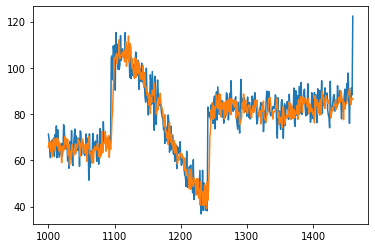

In [35]:
lin_forecast = model_forecast(model, series[split_time - ws:-1], ws)
lin_forecast = lin_forecast[:,0]
plt.plot(time[split_time:],x_valid)
plt.plot(time[split_time:],lin_forecast)

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[ws],activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=.9),
    loss=tf.keras.losses.Huber(), # Greater erros penalize using a linear funcion. Lower errors quadratic function
    metrics=["mae"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 1s 11ms/step - loss: 22.5464 - mae: 23.0382 - val_loss: 15.5048 - val_mae: 16.0026
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 10.3998 - mae: 10.8857 - val_loss: 8.5919 - val_mae: 9.0777
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 9.2174 - mae: 9.7053 - val_loss: 8.1825 - val_mae: 8.6673
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 8.5600 - mae: 9.0445 - val_loss: 7.5561 - val_mae: 8.0439
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 8.0876 - mae: 8.5729 - val_loss: 7.1418 - val_mae: 7.6232
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 7.6580 - mae: 8.1410 - val_loss: 6.8288 - val_mae: 7.3107
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 7.2657 - mae: 7.7493 - val_loss: 6.7597 - val_mae: 7.2494
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 7.0065 - mae: 7

Even when using more layers we didn't get a better val_mae. 

#### Using RNN to train our time series forecast

First we'll need to reshape our dataset as a three dimentional dataset to feed a RNN

In [47]:
def seq2seq_window_dataset(series, window_size,
                           batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [48]:
ws = 30
train_set = seq2seq_window_dataset(x_train, ws, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, ws, batch_size=128)

In [49]:
model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(100, return_sequences=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

model.fit(
    train_set, epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping]
)

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 49s 111ms/step - loss: 116.5130 - mae: 117.0115 - val_loss: 93.7522 - val_mae: 94.2522
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 68.0282 - mae: 68.5271 - val_loss: 15.4841 - val_mae: 15.9703
Epoch 3/500
8/8 [==============================] - 1s 65ms/step - loss: 38.4368 - mae: 38.9346 - val_loss: 50.0158 - val_mae: 50.5155
Epoch 4/500
8/8 [==============================] - 1s 64ms/step - loss: 26.1612 - mae: 26.6580 - val_loss: 16.4857 - val_mae: 16.9795
Epoch 5/500
8/8 [==============================] - 1s 63ms/step - loss: 19.9456 - mae: 20.4394 - val_loss: 25.3390 - val_mae: 25.8370
Epoch 6/500
8/8 [==============================] - 1s 61ms/step - loss: 15.6037 - mae: 16.0944 - val_loss: 26.4231 - val_mae: 26.9215
Epoch 7/500
8/8 [==============================] - 1s 62ms/step - loss: 13.8826 - mae: 14.3728 - val_loss: 21.1137 - val_mae: 21.6096
Epoch 8/500
8/8 [==============================] - 1s 60ms/step - loss

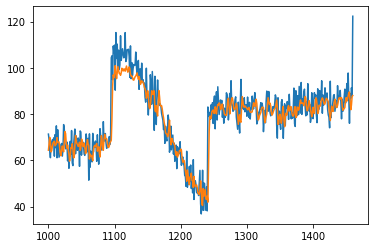

In [50]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], ws)
rnn_forecast = rnn_forecast[split_time - ws:-1, -1, 0]
plt.plot(time_valid,x_valid)
plt.plot(time_valid,rnn_forecast)

#### Using a stateful RNN

In [59]:
def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=window_size, drop_remainder=True)
  print(ds)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(1).prefetch(1)

In [62]:
ws = 30
train_set = sequential_window_dataset(x_train, ws)
valid_set = sequential_window_dataset(x_valid, ws)

model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

"""
There is no sense in maintein the state after we passed in all series, we should reset it.
"""
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

reset_states = ResetStatesCallback()
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


33/33 [==============================] - 2s 26ms/step - loss: 237.2564 - mae: 237.7564 - val_loss: 64.3735 - val_mae: 64.8735
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 38.5707 - mae: 39.0675 - val_loss: 11.5893 - val_mae: 12.0799
Epoch 3/500
33/33 [==============================] - 0s 14ms/step - loss: 19.5328 - mae: 20.0230 - val_loss: 10.5743 - val_mae: 11.0659
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 16.1126 - mae: 16.6026 - val_loss: 11.3374 - val_mae: 11.8307
Epoch 5/500
33/33 [==============================] - 0s 14ms/step - loss: 15.4592 - mae: 15.9478 - val_loss: 10.7147 - val_mae: 11.2043
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 14.9397 - mae: 15.4287 - val_loss: 9.9606 - val_mae: 10.4508
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 14.4024 - mae: 14.8927 - val_loss: 9.3212 - val_mae: 9.8108
Epoch 8/500
33/33 [==============================] - 0s 13ms/

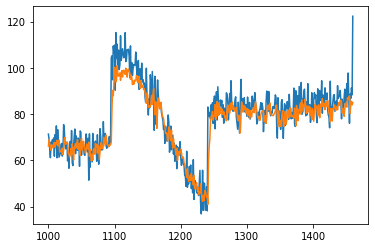

In [68]:
model = tf.keras.models.load_model("checkpoint.h5")
model.reset_states()
rnn_stateful_forecast = model.predict(series[np.newaxis,:, np.newaxis])
rnn_stateful_forecast = rnn_stateful_forecast[0,split_time - 1:-1, 0]
plt.plot(time_valid,x_valid)
plt.plot(time_valid,rnn_stateful_forecast)

#### Using Long-Short-Term-Memory (LSTM) models

In [69]:
ws = 30
train_set = sequential_window_dataset(x_train, ws)
valid_set = sequential_window_dataset(x_valid, ws)

model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

"""
There is no sense in maintein the state after we passed in all series, we should reset it.
"""
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

reset_states = ResetStatesCallback()
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


33/33 [==============================] - 5s 54ms/step - loss: 17.6128 - mae: 18.1087 - val_loss: 24.3667 - val_mae: 24.8659
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 14.2037 - mae: 14.6990 - val_loss: 20.2862 - val_mae: 20.7833
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 12.6388 - mae: 13.1304 - val_loss: 17.2712 - val_mae: 17.7677
Epoch 4/500
33/33 [==============================] - 1s 23ms/step - loss: 11.5448 - mae: 12.0362 - val_loss: 15.1727 - val_mae: 15.6684
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 10.6312 - mae: 11.1216 - val_loss: 13.2759 - val_mae: 13.7691
Epoch 6/500
33/33 [==============================] - 1s 21ms/step - loss: 10.0405 - mae: 10.5286 - val_loss: 12.1331 - val_mae: 12.6271
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 9.5084 - mae: 9.9942 - val_loss: 11.3271 - val_mae: 11.8191
Epoch 8/500
33/33 [==============================] - 1s 21ms/s

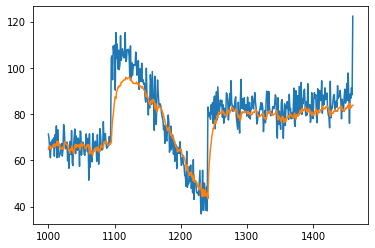

In [70]:
model = tf.keras.models.load_model("checkpoint.h5")
model.reset_states()
rnn_stateful_forecast = model.predict(series[np.newaxis,:, np.newaxis])
rnn_stateful_forecast = rnn_stateful_forecast[0,split_time - 1:-1, 0]
plt.plot(time_valid,x_valid)
plt.plot(time_valid,rnn_stateful_forecast)

#### Using CNNs

In [73]:
ws = 30
train_set = seq2seq_window_dataset(x_train, ws, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, ws, batch_size=128)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None,1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

"""
There is no sense in maintein the state after we passed in all series, we should reset it.
"""
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

reset_states = ResetStatesCallback()
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 6s 193ms/step - loss: 46.8501 - mae: 47.3480 - val_loss: 14.8965 - val_mae: 15.3845
Epoch 2/500
8/8 [==============================] - 1s 72ms/step - loss: 19.7798 - mae: 20.2745 - val_loss: 38.8321 - val_mae: 39.3320
Epoch 3/500
8/8 [==============================] - 1s 68ms/step - loss: 13.8269 - mae: 14.3195 - val_loss: 21.9139 - val_mae: 22.4113
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 12.1735 - mae: 12.6640 - val_loss: 29.0280 - val_mae: 29.5261
Epoch 5/500
8/8 [==============================] - 1s 67ms/step - loss: 10.4868 - mae: 10.9765 - val_loss: 25.5735 - val_mae: 26.0709
Epoch 6/500
8/8 [==============================] - 1s 70ms/step - loss: 9.1409 - mae: 9.6263 - val_loss: 20.5054 - val_mae: 21.0021
Epoch 7/500
8/8 [==============================] - 1s 74ms/step - loss: 8.3348 - mae: 8.8193 - val_loss: 17.3714 - val_mae: 17.8669
Epoch 8/500
8/8 [==============================] - 1s 149ms/step - loss: 7.84

5.11669

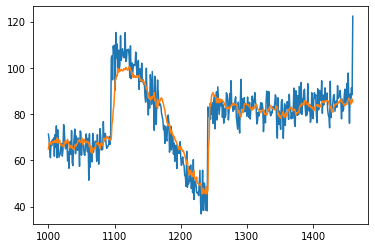

In [74]:
model = tf.keras.models.load_model("checkpoint.h5")

cnn_forecast = model_forecast(model, series[..., np.newaxis], ws)
cnn_forecast = cnn_forecast[split_time - ws:-1, -1, 0]
plt.plot(time_valid,x_valid)
plt.plot(time_valid,cnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

In [77]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
  model.add(
      tf.keras.layers.Conv1D(
          filters=32,
          kernel_size=2,
          strides=1,
          dilation_rate=dilation_rate,
          padding="causal",
          activation="relu"
      )
  )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.SGD(lr=3e-4, momentum=.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

"""
There is no sense in maintein the state after we passed in all series, we should reset it.
"""
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

reset_states = ResetStatesCallback()
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 3s 122ms/step - loss: 41.8803 - mae: 42.3795 - val_loss: 75.9588 - val_mae: 76.4588
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 39.8150 - mae: 40.3142 - val_loss: 65.6937 - val_mae: 66.1937
Epoch 3/500
8/8 [==============================] - 1s 62ms/step - loss: 24.8890 - mae: 25.3853 - val_loss: 42.7317 - val_mae: 43.2292
Epoch 4/500
8/8 [==============================] - 1s 62ms/step - loss: 16.2641 - mae: 16.7583 - val_loss: 13.1747 - val_mae: 13.6667
Epoch 5/500
8/8 [==============================] - 1s 59ms/step - loss: 11.0355 - mae: 11.5262 - val_loss: 10.6810 - val_mae: 11.1696
Epoch 6/500
8/8 [==============================] - 1s 60ms/step - loss: 8.0705 - mae: 8.5566 - val_loss: 8.4588 - val_mae: 8.9446
Epoch 7/500
8/8 [==============================] - 1s 60ms/step - loss: 6.4346 - mae: 6.9179 - val_loss: 8.0107 - val_mae: 8.4993
Epoch 8/500
8/8 [==============================] - 1s 60ms/step - loss: 5.6118 - 

4.62928

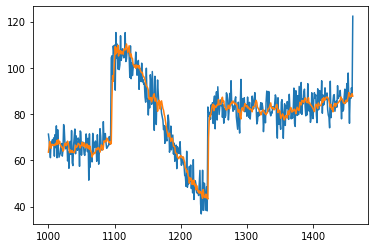

In [78]:
model = tf.keras.models.load_model("checkpoint.h5")

cnn_forecast = model_forecast(model, series[..., np.newaxis], ws)
cnn_forecast = cnn_forecast[split_time - ws:-1, -1, 0]
plt.plot(time_valid,x_valid)
plt.plot(time_valid,cnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

### Conclusion

We finally found a model that matches the heuristic used. This show us that ML may not be the best pratice to any problem. 